# Analiza c.d.
Paweł Bęza <br>
Artur Mazur

## Prepare dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [2]:
sessions = pd.read_csv("merged_dataset", sep=' ')
sessions = sessions.sample(frac=1, random_state=42) # shuffle dataset

In [3]:
sessions = sessions.drop(['session_id', 'user_id', 'unique_categories'], axis=1)

### One hot encoding

In [4]:
sessions = pd.get_dummies(sessions, columns = ['offered_discount', 'weekday'])

### Divide into training 60%, validation 20% and test set 20%

In [5]:
records_num = len(sessions)
train, validation, test = np.split(sessions.sample(frac=1, random_state=42), [int(.6*records_num), 
                                                                              int(.8*records_num)])

In [6]:
print('Size of entire dataset: ', records_num)
print('Size of training set: ', len(train))
print('Size of validation set: ', len(validation))
print('Size of test set: ', len(test))

Size of entire dataset:  37863
Size of training set:  22717
Size of validation set:  7573
Size of test set:  7573


In [7]:
X_train = sessions.drop('purchase', axis = 1)
Y_train = sessions['purchase']

X_train.head()

,duration,weekend,hour,unique_item_views,item_views,click_rate,offered_discount_0,offered_discount_5,offered_discount_10,offered_discount_15,offered_discount_20,weekday_0.0,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0
18097,0.0,True,16.0,1.0,1.0,0.000000,1,0,0,0,0,0,0,0,0,0,0,1
8504,81.0,False,13.0,1.0,2.0,1.481481,0,0,0,1,0,0,0,0,1,0,0,0
15727,732.0,False,23.0,5.0,5.0,0.409836,1,0,0,0,0,0,1,0,0,0,0,0
21433,504.0,True,23.0,6.0,6.0,0.714286,0,0,1,0,0,0,0,0,0,0,0,1
4968,0.0,False,0.0,1.0,1.0,0.000000,1,0,0,0,0,1,0,0,0,0,0,0


## Korelacja między atrybutami

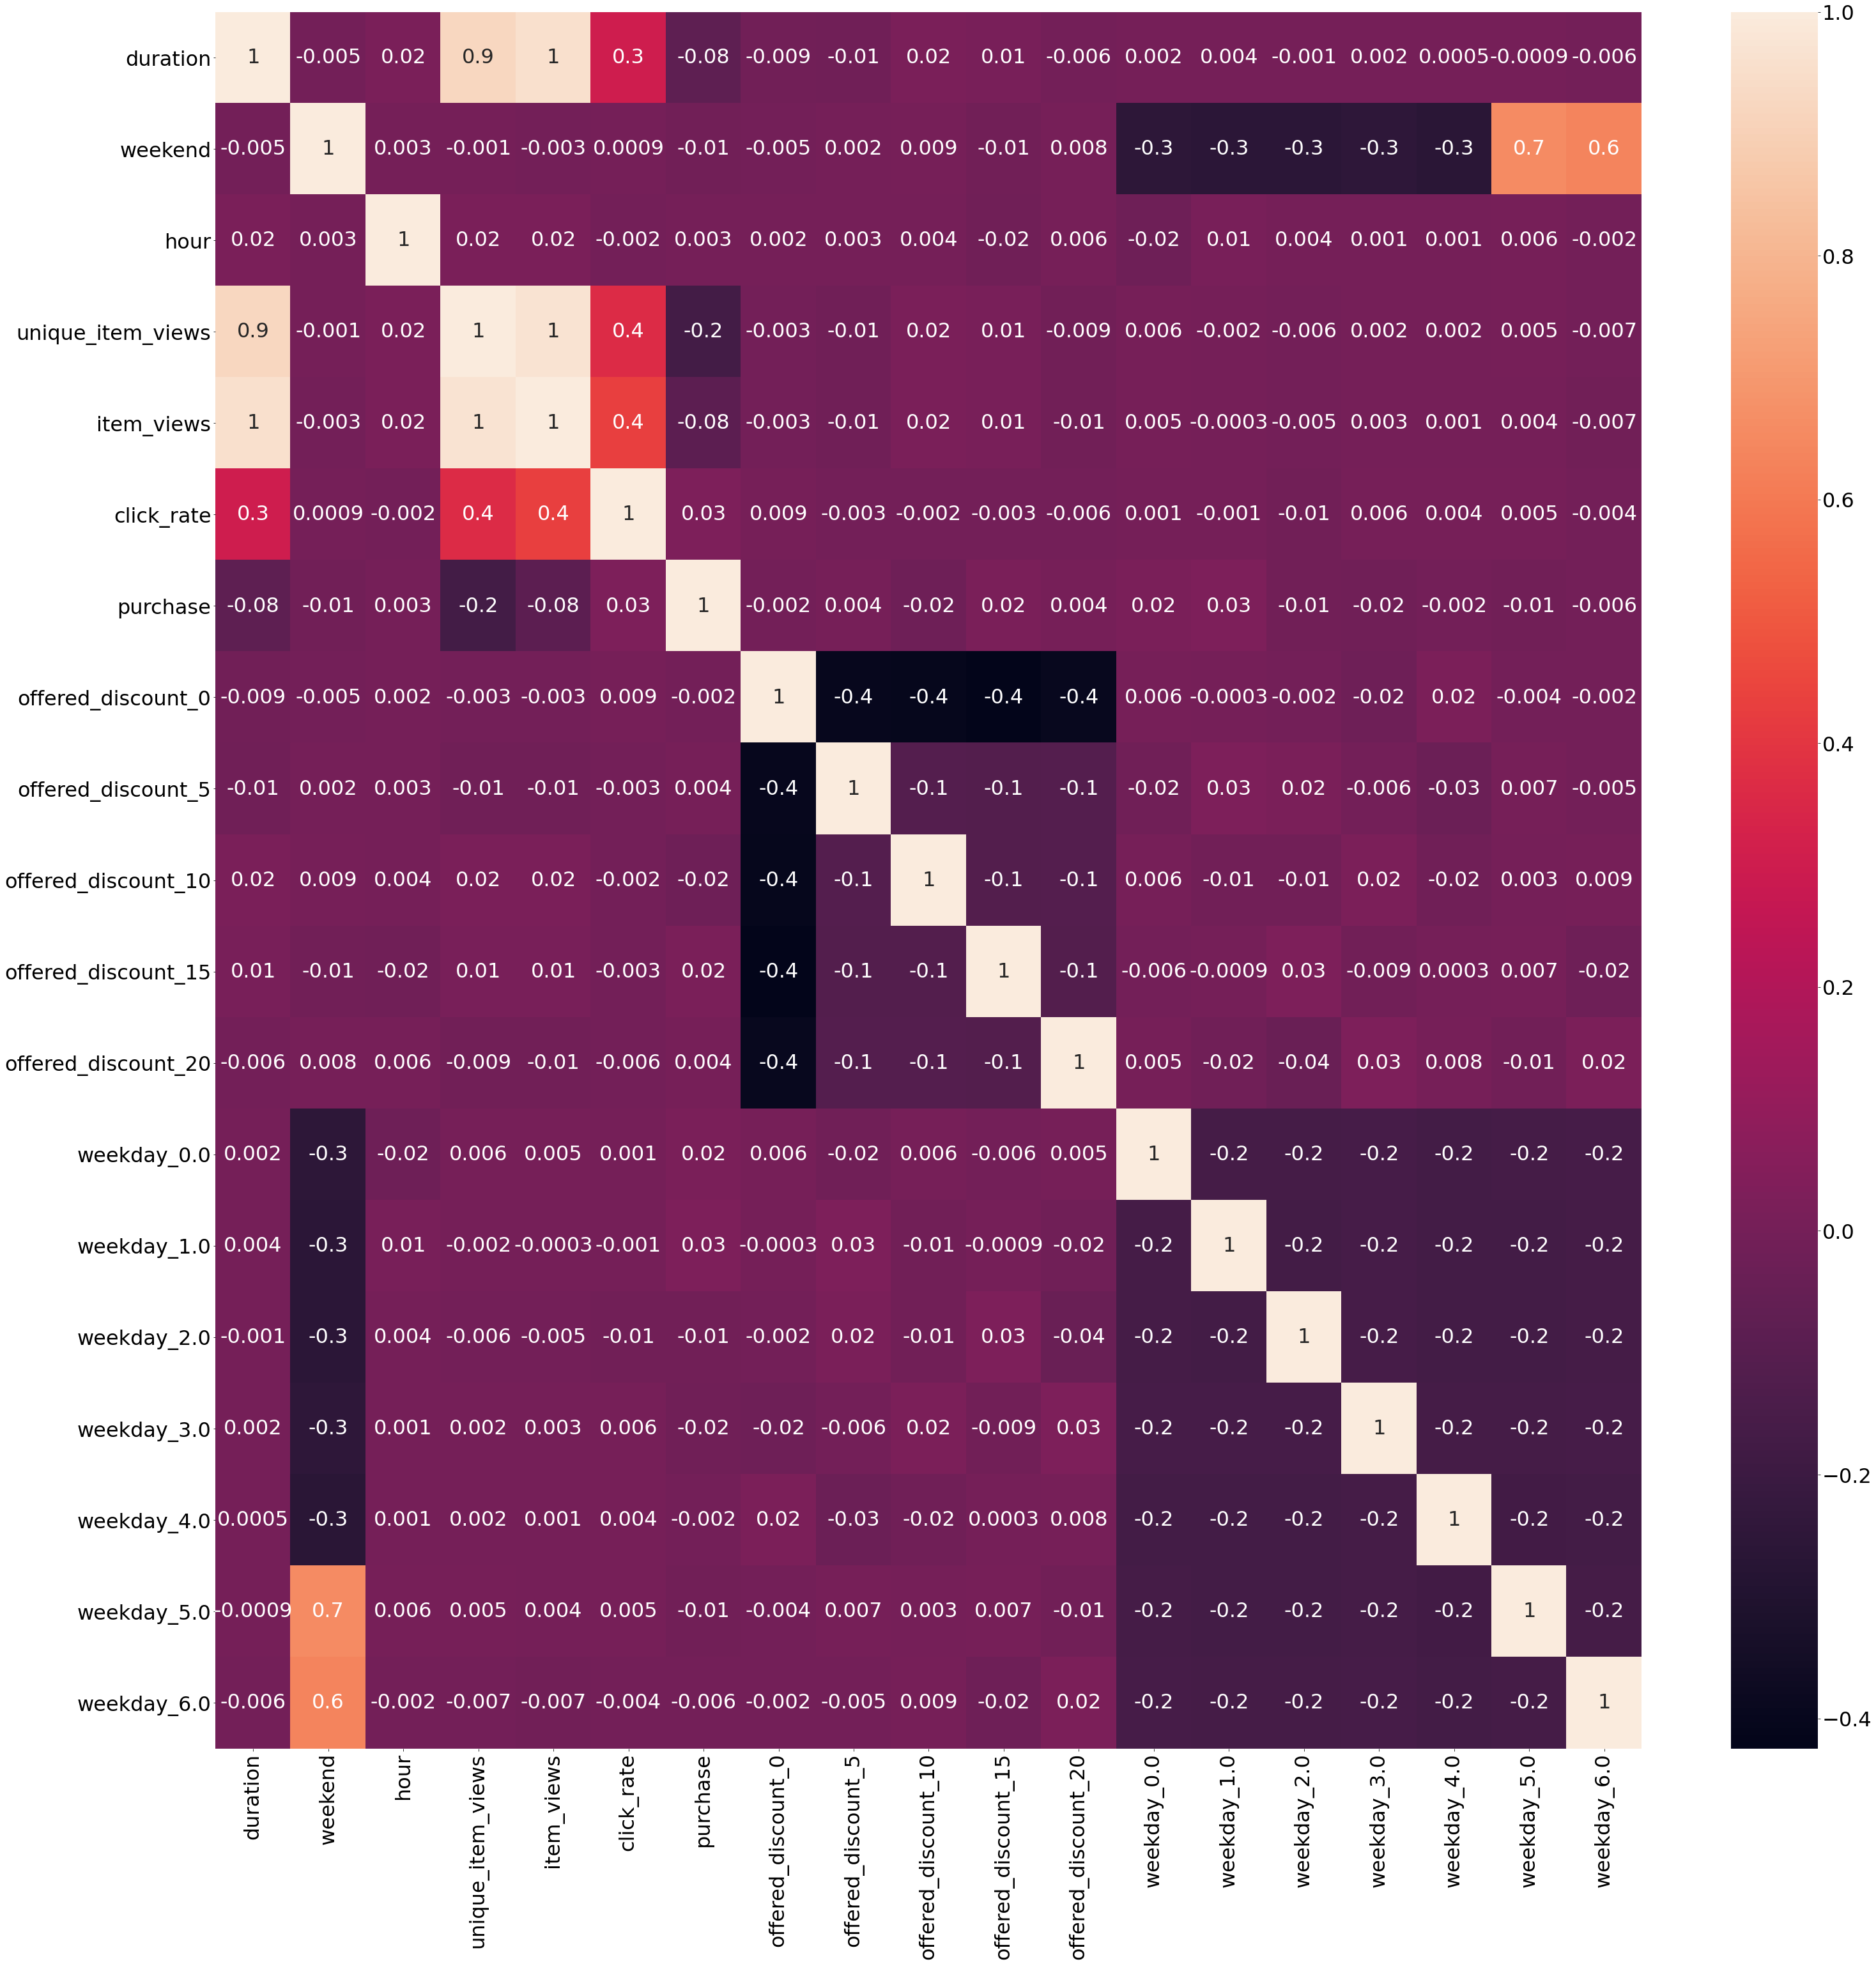

In [8]:
plt.rcParams['figure.figsize'] = [50, 50]
plt.rcParams.update({'font.size': 32})

sns.heatmap(
    train.corr(method = 'spearman'),
    xticklabels = sessions.columns,
    yticklabels = sessions.columns,
    annot=True,
    fmt='0.1g'
)

Zauważamy bardzo wysoką korelacje między długością trwania sesji *duration* a liczbą wyświetlonych przedmiotów w sumie *item_views* oraz liczbą wyświetlonych unikalnych przedmiotów *unique_item_views*. Dlatego w dalszej części zrezygnujemy z części wymienionych atrybutów. Wybór będzie zależeć od wartości chi kwadrat dla poszczególnych atrybutów.

In [9]:
X_train = sessions.drop('purchase', axis = 1)
Y_train = sessions['purchase']

X_train.head()

,duration,weekend,hour,unique_item_views,item_views,click_rate,offered_discount_0,offered_discount_5,offered_discount_10,offered_discount_15,offered_discount_20,weekday_0.0,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0
18097,0.0,True,16.0,1.0,1.0,0.000000,1,0,0,0,0,0,0,0,0,0,0,1
8504,81.0,False,13.0,1.0,2.0,1.481481,0,0,0,1,0,0,0,0,1,0,0,0
15727,732.0,False,23.0,5.0,5.0,0.409836,1,0,0,0,0,0,1,0,0,0,0,0
21433,504.0,True,23.0,6.0,6.0,0.714286,0,0,1,0,0,0,0,0,0,0,0,1
4968,0.0,False,0.0,1.0,1.0,0.000000,1,0,0,0,0,1,0,0,0,0,0,0


## Selekcja atrybutów Chi-kwadrat

In [10]:
list_one =[]
feature_ranking = SelectKBest(chi2, k=5)
fit = feature_ranking.fit(X_train, Y_train)

for i, (score, feature) in enumerate(zip(feature_ranking.scores_, X_train.columns)):
    list_one.append((score, feature))
    
dfObj = pd.DataFrame(list_one) 
dfObj.sort_values(by=[0], ascending = False)

,0,1
0,101830.962229,duration
3,1377.266723,unique_item_views
4,445.216746,item_views
5,129.981507,click_rate
12,29.017788,weekday_1.0
2,13.792344,hour
8,12.298015,offered_discount_10
11,9.299896,weekday_0.0
14,8.837183,weekday_3.0
9,7.406322,offered_discount_15


Spośród atrybutów *duration*, *unique_item_views* oraz *item_views* odrzucamy atrybut *unique_item_views* oraz *item_views*, ponieważ mają mniejszą wartość statystyki chi kwadrat od *duration* i jednocześnie są z tym parametrem wysoce skorelowane co widać w macierzy korelacji powyżej.

Dodatkowo usuwamy atrybuty, dla których wartość statystki chi kwadrat jest bardzo bliska 0 tj. atrybuty *offered_discount_0* oraz *offered_discount_5*

In [11]:
dropped_cols = ['unique_item_views', 'item_views', 'offered_discount_0', 'offered_discount_5']
                
X_train = X_train.drop(dropped_cols, axis=1)
validation = validation.drop(dropped_cols, axis=1)
test = test.drop(dropped_cols, axis=1)

X_train.head()

,duration,weekend,hour,click_rate,offered_discount_10,offered_discount_15,offered_discount_20,weekday_0.0,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0
18097,0.0,True,16.0,0.000000,0,0,0,0,0,0,0,0,0,1
8504,81.0,False,13.0,1.481481,0,1,0,0,0,0,1,0,0,0
15727,732.0,False,23.0,0.409836,0,0,0,0,1,0,0,0,0,0
21433,504.0,True,23.0,0.714286,1,0,0,0,0,0,0,0,0,1
4968,0.0,False,0.0,0.000000,0,0,0,1,0,0,0,0,0,0


## Wybór wejść i wyjść modelu

Zatem naszymi danymi wejściowymi modelu będą następujące atrybuty:
* duration - długość trwania sesji w sekundach
* click_rate - liczba zdarzeń(event'ów) do aktualnego rekordu na minutę
* weekday_0.0 - weekday_6.0 - one hot encoding dni tygodnia
* hour - godzina
* offered_discount_10, 15, 20 - one hot encoding 10, 15 oraz 20%-owej zniżki
* weekend -  wartość boolowska odpowiadająca na pytanie czy sesja trwa w weekend

Natomiast zmienną celu jest prawdopoboieństwo tego, że sesja zakończy się zakupem. Model będzie zwracał, że sesja zakończy się zakupem jeśli prawdopodobieństwo zakupu będzie większe od pewnej wartości granicznej.

## Regresja logistyczna

In [12]:
X_train = sessions.drop('purchase', axis = 1)
Y_train = sessions['purchase']

X_train.head()

,duration,weekend,hour,unique_item_views,item_views,click_rate,offered_discount_0,offered_discount_5,offered_discount_10,offered_discount_15,offered_discount_20,weekday_0.0,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0
18097,0.0,True,16.0,1.0,1.0,0.000000,1,0,0,0,0,0,0,0,0,0,0,1
8504,81.0,False,13.0,1.0,2.0,1.481481,0,0,0,1,0,0,0,0,1,0,0,0
15727,732.0,False,23.0,5.0,5.0,0.409836,1,0,0,0,0,0,1,0,0,0,0,0
21433,504.0,True,23.0,6.0,6.0,0.714286,0,0,1,0,0,0,0,0,0,0,0,1
4968,0.0,False,0.0,1.0,1.0,0.000000,1,0,0,0,0,1,0,0,0,0,0,0
